# Pairs-Trading (Beta Neutral) Strategy Analysis

The beta neutral trading strategy is a market-neutral approach designed to eliminate systematic market risk by constructing a portfolio that has a net beta of zero. This strategy aims to generate alpha (excess returns above the market) by taking both long and short positions in securities such that the overall portfolio is insulated from broad market movements.

Key Concepts:
- **Beta**: A measure of a security's volatility in relation to the overall market. A beta of 1 indicates that the security moves with the market, a beta greater than 1 indicates higher volatility than the market, and a beta less than 1 indicates lower volatility.
- **Market Neutral**: A strategy that seeks to minimize exposure to market risk, focusing on generating returns from the individual performance of securities rather than market movements.

Here's how it works:

- **Identifying a Pair / Basket of Tokens**: Identify a set of tokens with varying betas.
- **Calculating Beta**: Use historical price data to calculate the beta of each token relative to a benchmark token (e.g., BTC and ETH). This can be done using regression analysis where the token's returns are regressed against the benchmark's returns.
- **Constructing the Portfolio**: 
    - **Long Positions**: Select tokens with positive alpha (expected to outperform their beta-implied returns) and go long on these.
    - **Short Positions**: Select tokens with negative alpha (expected to underperform their beta-implied returns) and short these.
    - Ensure the weighted average beta of the long positions is equal to the weighted average beta of the short positions, resulting in a net beta of zero.
- **Position Sizing**: Calculate the dollar amount for each position to ensure that the portfolio remains beta neutral. This involves balancing the dollar value of long and short positions based on their respective betas.
- **Monitoring and Rebalancing**: Regularly monitor the portfolio to ensure it remains beta neutral. Adjust positions as necessary to maintain the desired beta neutrality, especially if there are significant changes in the market or individual tokens.

In this notebook, the pair trading negative / low correlation strategy is demonstrated using cryptocurrency price data sourced from the Binance, OKX, and Bybit APIs.

Special Note:
There are **two notebooks** for Pairs-Trading (Beta Neutral) Strategy Analysis. **This notebook allow users to manually set the portfolio weights and plot the returns of portfolio compared to market. The other notebook uses CVXPY package to optimise portfolio weights given a set of data.**

## Credits

This notebook references [quant_playground](https://github.com/rukawa917/quant_playground) repository by [rukawa917](https://github.com/rukawa917) and [mkt_neutral.ipynb](https://gist.github.com/FilippoGuerrieri26/8086c42db442835234dd61ea6c07decb) by [FilippoGuerrieri26](https://gist.github.com/FilippoGuerrieri26). I want to extend my sincere gratitude to them for creating this valuable resource.


## Prepare your Environment

Ensure that the correct kernel is selected for this notebook. If you are following the instruction in *README.md*, the kernel is 'crypto-trading-strategies'. To check, click on 'Kernel' at the top bar, select 'Change Kernel...' and select the correct kernel. For convenience, ensure that 'Always start the preferred kernel' is ticked. Click 'Select' to confirm the setting.

Install the environment's dependencies using the command below. After installation, restart the kernel to use the updated packages. To restart, click on 'Kernel' at the top bar and select 'Restart Kernel' and click on 'Restart'. Please skip this step if you have already done it.

In [ ]:
pip install -r requirements.txt

## Import packages

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import sys
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import coint
from itertools import combinations
from statsmodels.tsa.stattools import coint
from utils import calculate_profit, plot_strategy
from data_manager import load_ts_df, process_data, sanitize_data
from typing import List
import cvxpy as cvx
import warnings

pd.set_option('display.max_rows', None)
warnings.filterwarnings("ignore")

## Process Price Dataframe

- Before proceeding, ensure that the price data has been downloaded using ***'data_manager.py'***.
- Enter the ***cex*** (Centralized Exchange) and ***interval*** values used for data download to load the relevant *.pkl* files and retrieve the dataframe.
- You can specify a batch of pairs to load using the ***selected_pairs*** variable. The key represents the pair and its value represents the direction it must take (1: Long, -1: Short, 0: Does not matter). Unlike other notebooks, no pairs will be selected if the dictionary is empty.
- Note that some pairs might be new and may lack sufficient data within the downloaded timeframe. Such pairs will be removed based on the ***nan_remove_threshold*** setting, which defines the maximum percentage of NaN values allowed relative to the total data points. For example, with a ***nan_remove_threshold*** of 0.1, if a pair has 100 data points and 15 are NaN, the pair will be excluded.
- From the remaining pairs, you can filter the top N rolling or mean volume pairs using the ***top_n_volume_pairs*** and ***volume_filter_mode*** parameter. 
- This part of the code will also ensure that all timeseries columns have the same number of data points.
- The earliest and latest dates for all pairs will be recorded. These dates can then be used to determine the timeframe for slicing the data in the next step.

## Inputs

In [2]:
##### INPUTS #####
cex = 'binance'
interval = '1d'
nan_remove_threshold = 0.0

# Select only the pairs below to analyse. The key represents the pair and its value represents the pair's contribution to the portfolio 
# weight. The sum of the absolute contributions must be equal to 1. Eg. selected_pairs = {'SOLUSDT': 0.8, 'ALTUSDT': -0.2}. This means 
# 0.8 of the portfolio is set to long SOLUSDT and 0.2 of the portfolio is set to short ALTUSDT. Furthermore, abs(0.8) + abs(-0.2) = 
# 0.8 + 0.2 = 1.
selected_pairs = {'SOLUSDT': 0.7, 'ETHUSDT': -0.3}

# Select the benchmark token.
benchmark_token = 'BTCUSDT'

# Select only the top N mean volume pairs from the selected pairs to analyse.
top_n_volume_pairs = 100

# Select volume filter mode. Options: ['rolling', 'mean'].
volume_filter_mode = 'rolling'

# Rolling Window
rolling_window = 3
##################

In [3]:
selected_pairs[benchmark_token] = 0
absolute_weight_list = [abs(weight) for weight in selected_pairs.values()]
portfolio_weights_sum = sum(absolute_weight_list)

if portfolio_weights_sum != 1:
    print("\n")
    print("The sum of the absolute contributions must be equal to 1. Please change before proceeding.")
    print("\n")

In [4]:
print("\nMode: Pairs-Trading (Beta Neutral) Strategy")
print("CEX: {}".format(str(cex).capitalize()))
print("Interval: {}".format(interval))
print("NaN Remove Threshold: {}".format(nan_remove_threshold))
print("Selected pairs to analyse: {}".format(list(selected_pairs.keys())))
print("Benchmark Token: {}".format(benchmark_token))
print("Top N Volume Pairs: {}".format(top_n_volume_pairs))
print("Volume Filter Mode: {}".format(str(volume_filter_mode).capitalize()))
print("Rolling Window: {}".format(rolling_window))

merged_df = process_data('beta_neutral', cex, interval, nan_remove_threshold, selected_pairs,
                 top_n_volume_pairs, volume_filter_mode)

print("\n")


Mode: Pairs-Trading (Beta Neutral) Strategy
CEX: Binance
Interval: 1d
NaN Remove Threshold: 0.0
Selected pairs to analyse: ['SOLUSDT', 'ETHUSDT', 'BTCUSDT']
Benchmark Token: BTCUSDT
Top N Volume Pairs: 100
Volume Filter Mode: Rolling
Rolling Window: 3
Successfully loaded candlestick dataframe for all available pairs.

Earliest time series start date: 2024-07-17
Latest time series end date: 2024-08-06




## Sanitize the dataframe

- Slice the dataframe according to the specified ***start_date*** and ***end_date***. Choose ***start_date*** and ***end_date*** within the timeframe shown by the output of the previous cell.
- Interpolate any missing values in the dataframe.
- If the interpolation fails, just backfill with the latest valid value.
- Verify that all is as expected with an `assert` and check the shapes of 2 random pairs, which should have the same dimensions.

## Inputs

In [5]:
##### INPUTS #####
start_date = '2024-07-17' # refer to the previous output to set
end_date = '2024-08-06' # refer to the previous output to set
##################

In [6]:
print("\n")

data_sanitized, sorted_available_pairs = sanitize_data(merged_df, start_date, end_date)

if data_sanitized:
    print("-Data Check-")
    keys = list(data_sanitized.keys())
    count = 0

    for key in keys:
        print("{}'s Data Shape: {}".format(key, data_sanitized[key].shape))
        count+=1

        if count == 2:
            break
            
else:
    print("No data found.")

print("\n")



-Data Check-
BTCUSDT's Data Shape: (20, 1)
ETHUSDT's Data Shape: (20, 1)




## Compute Percentage Returns

To compute percentage returns with a time series of close data, you first need to calculate the daily returns by finding the percentage change between consecutive prices. This can be done using the formula below:
$$Percentage \space Return = \frac{Price_{t} - Price_{t-1}}{Price_{t-1}} \times 100$$
1. ${Price_{t}}$ is the calculated price on day t.
2. ${Price_{t-1}}$ is the calculated price on the previous candlestick.

In a pandas DataFrame, this can be efficiently computed using the pct_change() method on the price column. The resulting series represents the daily percentage returns, reflecting the day-to-day performance of the asset. Summarizing or compounding these daily returns over longer periods can provide insights into the overall performance of the asset over time.

In [7]:
print("\n")

returns = pd.DataFrame()

for pair, df in data_sanitized.items():
    tmp_return_df = df['Close'].pct_change().dropna().to_frame(name=pair)
    returns = pd.merge(returns, tmp_return_df, how='outer', left_index=True, right_index=True)
returns = returns.T.sort_index().T

print("-Data Check-")
print("Percentage Returns' Data Shape (should be 1 row lesser than printed above): {}".format(returns.shape))
print("\n")




-Data Check-
Percentage Returns' Data Shape (should be 1 row lesser than printed above): (19, 3)




In [8]:
print("\n")

full_return_df = returns.reset_index().set_index('Open Time')

print("-Data Check-")
print("Full Returns' Data Shape: {}".format(full_return_df.shape))

print("\n")



-Data Check-
Full Returns' Data Shape: (19, 3)




## Full Covariance Matrix

In [9]:
Sigma = full_return_df.cov()
Sigma

,BTCUSDT,ETHUSDT,SOLUSDT
BTCUSDT,0.000446,0.000474,0.000643
ETHUSDT,0.000474,0.000750,0.000688
SOLUSDT,0.000643,0.000688,0.001302


## Full Correlation Matrix

In [10]:
std_dev = np.sqrt(np.diag(Sigma))
std_dev_outer = np.outer(std_dev, std_dev)
correlation_matrix = Sigma / std_dev_outer
np.fill_diagonal(correlation_matrix.values, 1)
correlation_matrix

,BTCUSDT,ETHUSDT,SOLUSDT
BTCUSDT,1.000000,0.81913,0.843597
ETHUSDT,0.819130,1.00000,0.696100
SOLUSDT,0.843597,0.69610,1.000000


## Calculate Betas given the Datetime Period

In [11]:
print("\n")

betas = Sigma[benchmark_token] / Sigma.loc[benchmark_token, benchmark_token]
betas_without_benchmark = betas.drop(benchmark_token)
betas_without_benchmark = betas_without_benchmark.sort_values(ascending=False)

print("-Data Check-")
print("Betas:")
print(betas_without_benchmark)

betas_without_benchmark = betas_without_benchmark.sort_index()

print("\n")



-Data Check-
Betas:
SOLUSDT    1.44212
ETHUSDT    1.06266
Name: BTCUSDT, dtype: float64




## Covariance Matrix without Benchmark

In [12]:
full_return_df_without_benchmark = full_return_df.drop(benchmark_token, axis=1)  # since we are using BTC as the benchmark
final_Sigma = full_return_df_without_benchmark.cov()
final_Sigma

,ETHUSDT,SOLUSDT
ETHUSDT,0.000750,0.000688
SOLUSDT,0.000688,0.001302


## Setting Portfolio Weights

In [13]:
weights = []

for col in final_Sigma.columns:
    weights.append(selected_pairs[col])

## Plot Portfolio Weights

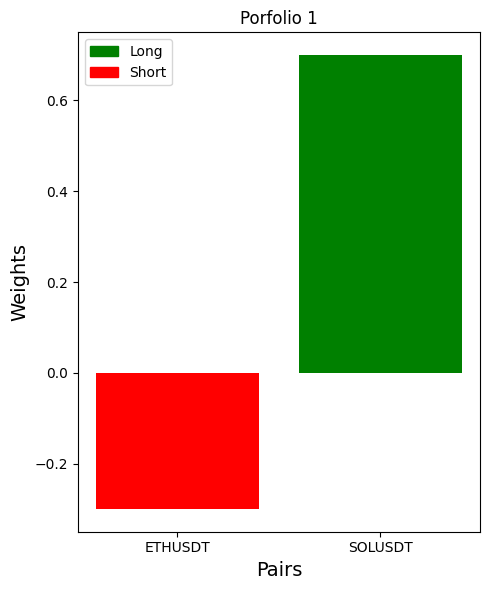

In [14]:
w = pd.Series(weights, index=final_Sigma.columns)

index = list(w.index)
values = list(w.values)

plt.figure(figsize=(5, 6))

long_patch = mpatches.Patch(color='green', label='Long')
short_patch = mpatches.Patch(color='red', label='Short')

colors = ['green' if val >= 0 else 'red' for val in values]
plt.bar(w.index, w.values, color=colors)
plt.title('Porfolio 1')
plt.xlabel('Pairs', fontsize=14)
plt.ylabel('Weights', fontsize=14)
plt.legend(handles=[long_patch, short_patch])

plt.tight_layout()
plt.show()

In [15]:
print("\n")

weights_df = pd.DataFrame(w, columns=['Weights'], index=w.index)
weights_df = weights_df.sort_values(by='Weights', ascending=False)
weights_df['Direction'] = weights_df['Weights'].apply(lambda x: 'Long' if x > 0 else 'Short')

print("Portfolio:")
print(weights_df)

print("\n")



Portfolio:
         Weights Direction
SOLUSDT      0.7      Long
ETHUSDT     -0.3     Short




## Using Fixed Portfolio Weights with Rolling Portfolio Beta

In [16]:
# rolling covariance matrix
rolling_cov = full_return_df.rolling(window=rolling_window).cov().dropna()
rolling_cov.head()

BTCUSDT   ETHUSDT       SOLUSDT
Open Time                                           
2024-07-21 BTCUSDT  0.000042  0.000034 -4.757489e-06
           ETHUSDT  0.000034  0.000041 -5.822874e-06
           SOLUSDT -0.000005 -0.000006  8.326280e-07
2024-07-22 BTCUSDT  0.000112  0.000125  1.413478e-04
           ETHUSDT  0.000125  0.000151  1.944902e-04

In [17]:
dates = list(set(rolling_cov.index.get_level_values(0)))
dates.sort()
weights_df = pd.DataFrame(index=pd.Index(dates).sort_values(), columns = full_return_df.columns)
weights_df = weights_df.drop(benchmark_token, axis=1)
betas_df = pd.DataFrame(index=pd.Index(dates).sort_values(), columns = full_return_df.columns)
betas_without_benchmark = betas_df.drop(benchmark_token, axis=1)

for i, dt in enumerate(dates):
    full_cov = rolling_cov.loc[dt]
    final_cov = full_cov.drop(benchmark_token).drop(benchmark_token, axis=1)
    final_beta = full_cov[benchmark_token].drop(benchmark_token) / full_cov.loc[benchmark_token, benchmark_token]

    weights_df.loc[dt, :] = weights
    betas_without_benchmark.loc[dt, :] = final_beta

In [18]:
print("\n")

print("-Data Check-")
print("Rolling Betas:")
print(betas_without_benchmark.head())
print(betas_without_benchmark.tail())
# print(betas_without_benchmark)

print("\n")



-Data Check-
Rolling Betas:
             ETHUSDT   SOLUSDT
2024-07-21  0.799259 -0.112133
2024-07-22  1.110996    1.2603
2024-07-23  0.332172  2.711316
2024-07-24  0.009958  1.671591
2024-07-25   -2.2354  0.934859
             ETHUSDT   SOLUSDT
2024-08-02  1.421915  1.192487
2024-08-03  1.228422    1.4426
2024-08-04  0.597964  2.023384
2024-08-05  1.337724 -0.363557
2024-08-06  1.405987  1.024865




In [19]:
print("\n")

print("-Data Check-")
print("Porfolio 1 Rolling Weights:")
print(weights_df.head())
print(weights_df.tail())
# print(weights_df)

print("\n")



-Data Check-
Porfolio 1 Rolling Weights:
           ETHUSDT SOLUSDT
2024-07-21    -0.3     0.7
2024-07-22    -0.3     0.7
2024-07-23    -0.3     0.7
2024-07-24    -0.3     0.7
2024-07-25    -0.3     0.7
           ETHUSDT SOLUSDT
2024-08-02    -0.3     0.7
2024-08-03    -0.3     0.7
2024-08-04    -0.3     0.7
2024-08-05    -0.3     0.7
2024-08-06    -0.3     0.7




In [20]:
print("\n")

print("-Data Check-")
print("Porfolio Beta:")
portfolio_beta = (weights_df.shift(1) * betas_without_benchmark).dropna().sum(axis=1)
print(portfolio_beta.head())
print(portfolio_beta.tail())
# print(portfolio_beta)

print("\n")



-Data Check-
Porfolio Beta:
2024-07-22    0.548911
2024-07-23     1.79827
2024-07-24    1.167126
2024-07-25    1.325021
2024-07-26    0.270532
dtype: object
2024-08-02    0.408166
2024-08-03    0.641293
2024-08-04     1.23698
2024-08-05   -0.655807
2024-08-06    0.295609
dtype: object




Text(0.5, 1.0, 'Mkt Neutral Portfolio Rolling Beta to Market')

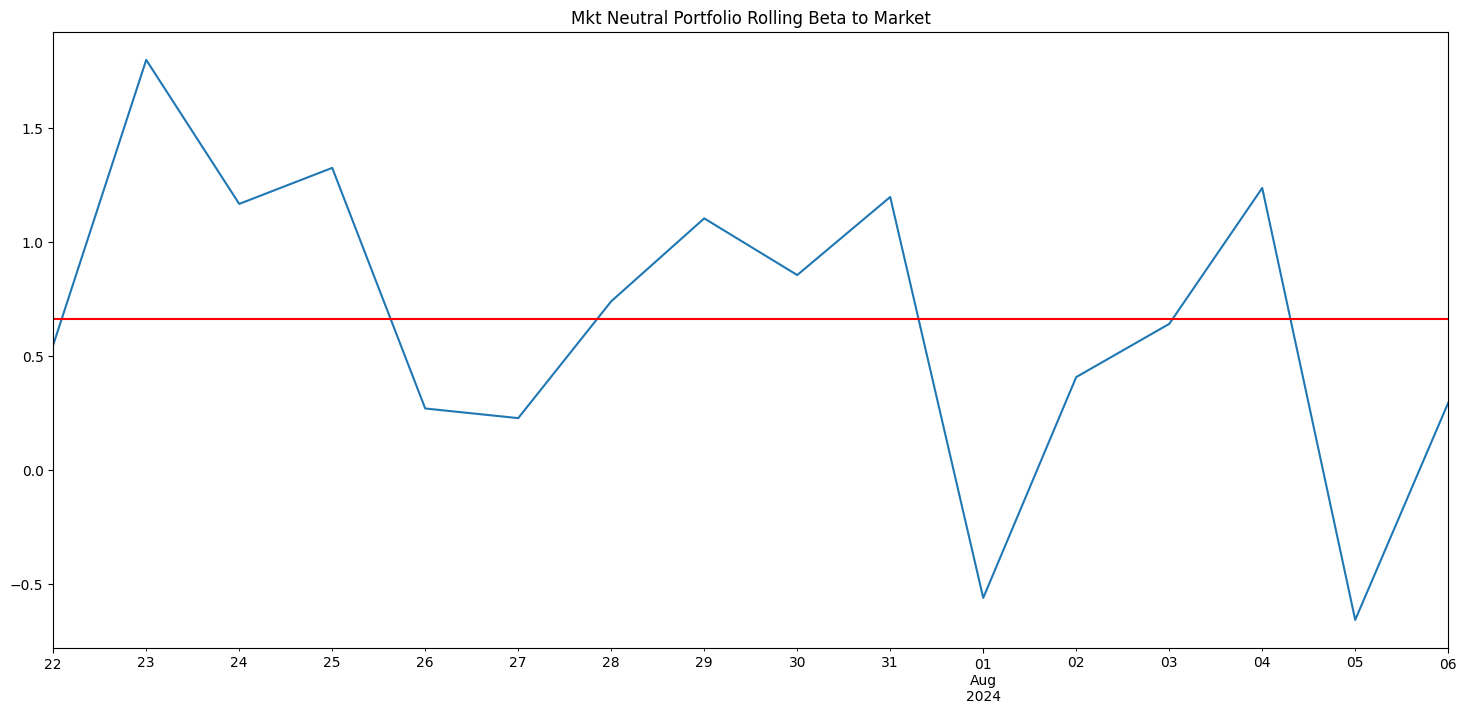

In [21]:
portfolio_beta.plot(figsize=(18, 8))
plt.axhline(portfolio_beta.mean(), color="red")
plt.title("Mkt Neutral Portfolio Rolling Beta to Market")

Text(0.5, 1.0, 'Backtest of Market Neutral Portfolio Return')

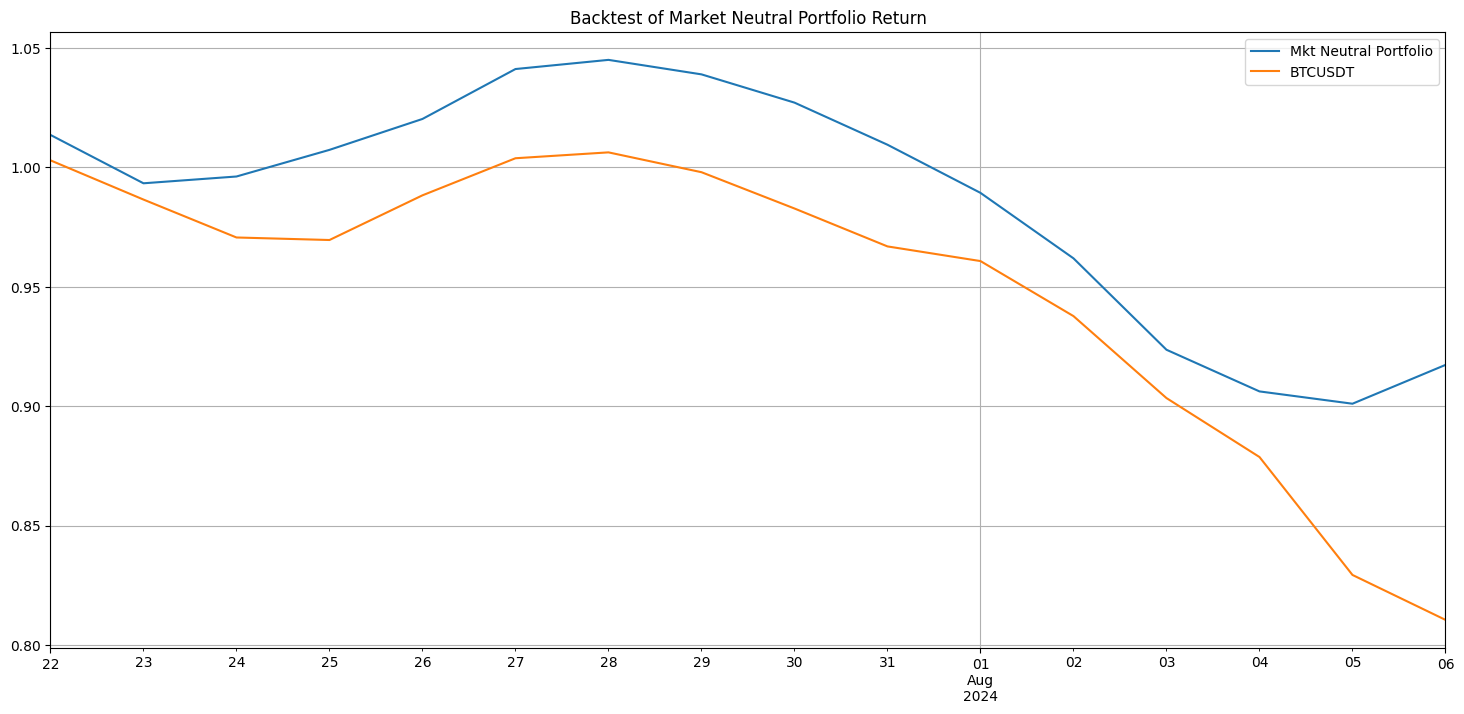

In [22]:
full_return_df_copy = full_return_df.copy()

weights_df = weights_df.T.sort_index().T
full_return_df = full_return_df.T.sort_index().T.drop(benchmark_token, axis=1)

portfolio_ret = (weights_df.shift(1) * full_return_df).dropna().sum(axis=1)
(1 + portfolio_ret).cumprod().plot(figsize=(18, 8), label="Mkt Neutral Portfolio")
(1 + full_return_df_copy.loc[portfolio_ret.index][benchmark_token]).cumprod().plot()
plt.grid()
plt.legend()
plt.title("Backtest of Market Neutral Portfolio Return")